# Imports and Data Reading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import seaborn as sns
import os
import numpy as np
from scipy.stats.mstats import winsorize

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

plt.style.use('dark_background')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


def model_display(train):
    '''
    input: train dataframe
    output: basic descriptions
    '''
    # data shape
    print(f'train shape: {train.shape}')
    print('='*50)

    # datatypes present
    print('train dtypes:')
    display(train.dtypes)
    print('='*50)

    # data descriptions
    print('train describe:}')
    display(train.describe())
    print('='*50)

    # display head
    display(train.head())




# reading training data
raw_train = pd.read_parquet('./training_data.parquet')

# view data
model_display(raw_train)

train shape: (12100, 9)
train dtypes:


date       datetime64[ns]
firm_id             int64
macro1             object
macro2            float64
price             float64
firm1             float64
firm2             float64
firm3             float64
ret               float64
dtype: object

train describe:}


,date,firm_id,macro2,price,firm1,firm2,firm3,ret
count,12100,12100.000000,12100.000000,12100.000000,12100.000000,12100.000000,12100.000000,12100.000000
mean,2020-03-01 00:00:00,49.500000,-0.582961,141.188960,0.024705,0.021550,0.009670,-0.001010
min,2020-01-01 00:00:00,0.000000,-2.986708,7.002039,-1.400862,-2.821420,-1.823757,-0.254047
25%,2020-01-31 00:00:00,24.750000,-1.201005,61.972243,-0.212695,-0.359549,-0.240290,-0.058832
50%,2020-03-01 00:00:00,49.500000,-0.616099,125.683412,0.019438,0.024645,0.006752,-0.006339
75%,2020-03-31 00:00:00,74.250000,0.008259,206.407505,0.253699,0.408466,0.253598,0.054219
max,2020-04-30 00:00:00,99.000000,1.831133,495.830892,2.316590,3.061011,2.623558,0.410168
std,NaN,28.867263,0.900100,93.012463,0.353883,0.576792,0.380795,0.082814


,date,firm_id,macro1,macro2,price,firm1,firm2,firm3,ret
0,2020-01-01,0,Recovery,-0.226155,276.226209,0.061042,0.034084,-0.847778,0.005584
1,2020-01-01,1,Recovery,-0.226155,83.808180,-1.202923,-1.810058,0.346567,-0.022935
2,2020-01-01,2,Recovery,-0.226155,149.170163,-0.872318,-0.861621,-0.092319,-0.029843
3,2020-01-01,3,Recovery,-0.226155,48.770836,0.831588,-0.136184,-1.165729,-0.003266
4,2020-01-01,4,Recovery,-0.226155,109.207015,0.827317,-1.984357,-1.408475,0.035171


In [40]:
# EDA: data structures, missing values detection and handling, outlier detection and handling
# feateng: create interactions lags and transformations
# train-val split: 80-20 split
# implement elastic net for return pred



# Data Typecasting + Downsizing

In [41]:
def downcasting_and_typecasting_columns(train):
    # iterate through columns of the train dataframe
    for col in tqdm(train.columns, total=len(train.columns), desc='downcasting train data'):
        # check the datatype and downcast if possible
        col_dtype = train[col].dtype

        # integer detection
        if pd.api.types.is_integer_dtype(col_dtype):
            
            # downcasting column to fit
            train[col] = pd.to_numeric(train[col], downcast='integer')
            print(f'downcasting integer column: {col}')

        # float detection
        elif pd.api.types.is_float_dtype(col_dtype):
            
            # downcasting column to fit
            train[col] = pd.to_numeric(train[col], downcast='float')
            print(f'downcasting float column: {col}')

        # datetime detection
        elif pd.api.types.is_datetime64_any_dtype(col_dtype):
            
            # typecasting datetime column
            try:
                print(f'typecasting datetime column: {col}')
                train[col] = pd.to_datetime(train[col])
            except Exception as e:
                print(f'failed to downcast datetime col: {col}')
                print(f'error: {e}')

        # object detection
        elif pd.api.types.is_object_dtype(col_dtype):
            
            # typecasting object column as category
            print(f'typecasting object column: {col}')
            train[col] = train[col].astype('category')

    return train
        
# before typecasting
print('='*50)
print('datatypes and size before downsizing and typecasting')
print('='*50)
display(raw_train.info())
print('='*50)

# running through funntion
raw_train = downcasting_and_typecasting_columns(raw_train)

# after typecasting
print('='*50)
print('datatypes and size after downsizing and typecasting')
print('='*50)
display(raw_train.info())
print('='*50)


datatypes and size before downsizing and typecasting
<class 'pandas.core.frame.DataFrame'>
Index: 12100 entries, 0 to 12099
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     12100 non-null  datetime64[ns]
 1   firm_id  12100 non-null  int64         
 2   macro1   12100 non-null  object        
 3   macro2   12100 non-null  float64       
 4   price    12100 non-null  float64       
 5   firm1    12100 non-null  float64       
 6   firm2    12100 non-null  float64       
 7   firm3    12100 non-null  float64       
 8   ret      12100 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 945.3+ KB


None

downcasting train data: 100%|██████████| 9/9 [00:00<00:00, 498.85it/s]

typecasting datetime column: date
downcasting integer column: firm_id
typecasting object column: macro1
downcasting float column: macro2
downcasting float column: price
downcasting float column: firm1
downcasting float column: firm2
downcasting float column: firm3
downcasting float column: ret
datatypes and size after downsizing and typecasting
<class 'pandas.core.frame.DataFrame'>
Index: 12100 entries, 0 to 12099
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     12100 non-null  datetime64[ns]
 1   firm_id  12100 non-null  int8          
 2   macro1   12100 non-null  category      
 3   macro2   12100 non-null  float32       
 4   price    12100 non-null  float32       
 5   firm1    12100 non-null  float32       
 6   firm2    12100 non-null  float32       
 7   firm3    12100 non-null  float32       
 8   ret      12100 non-null  float32       
dtypes: category(1), datetime64[ns](1), float32(6), int

None

# Data Visualizations - Firm Wise

firm_id: 95
feature: macro2


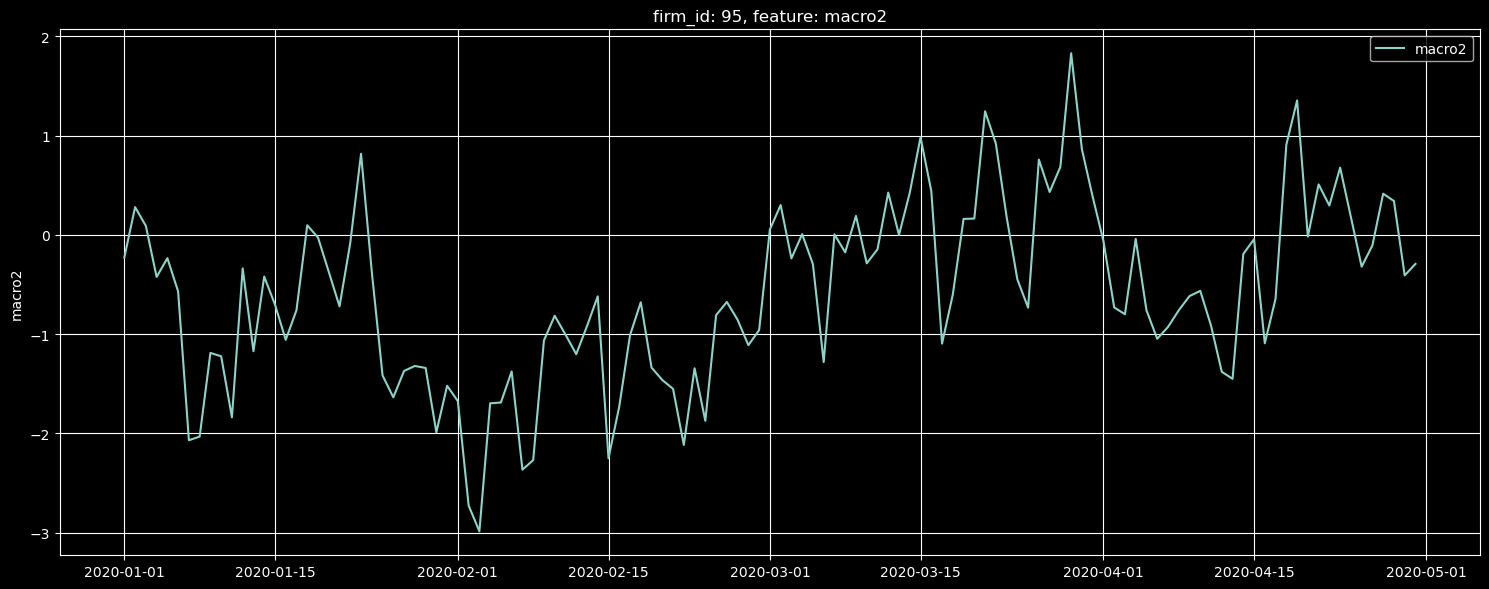

feature: price


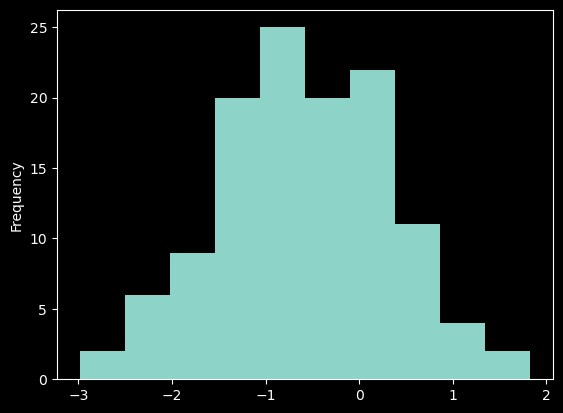

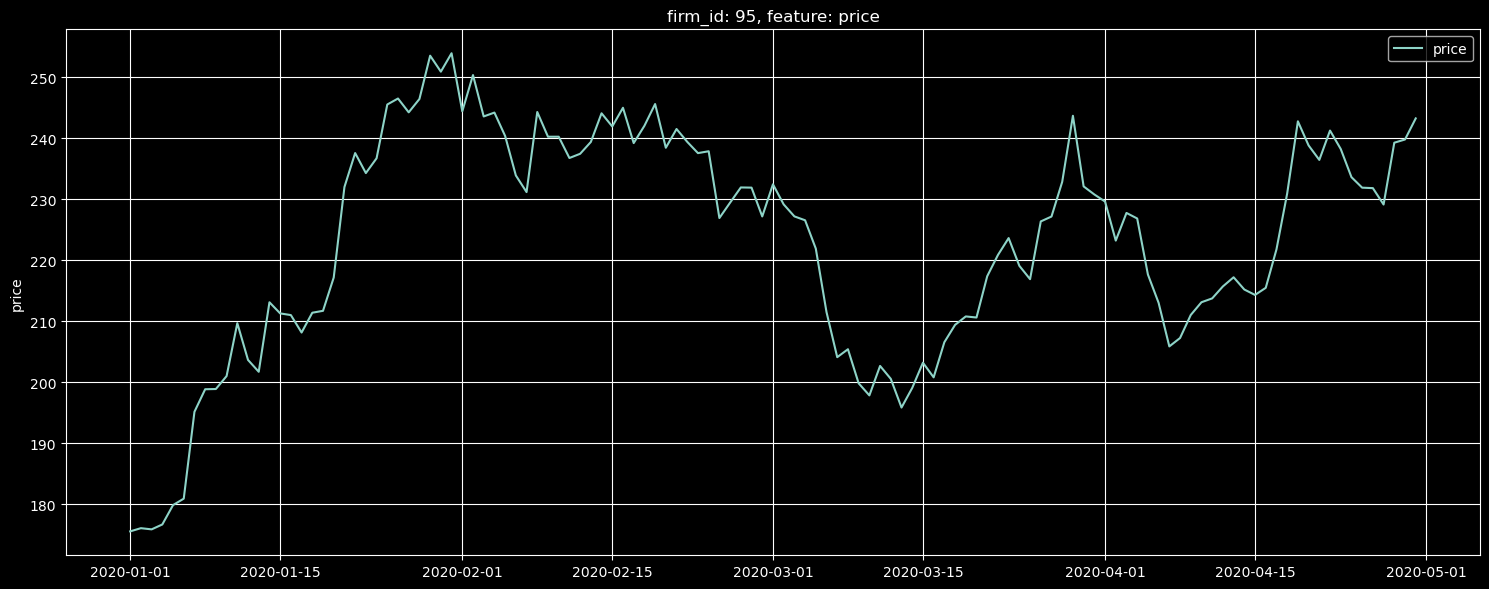

feature: firm1


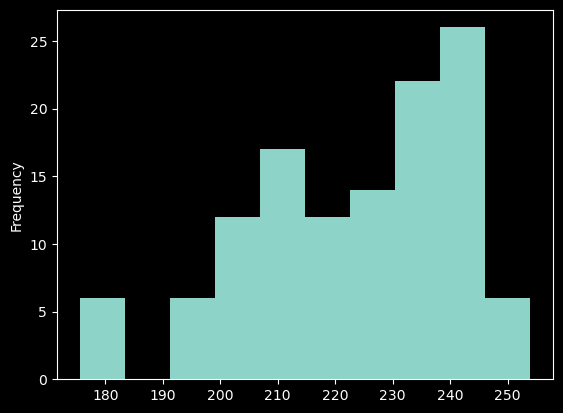

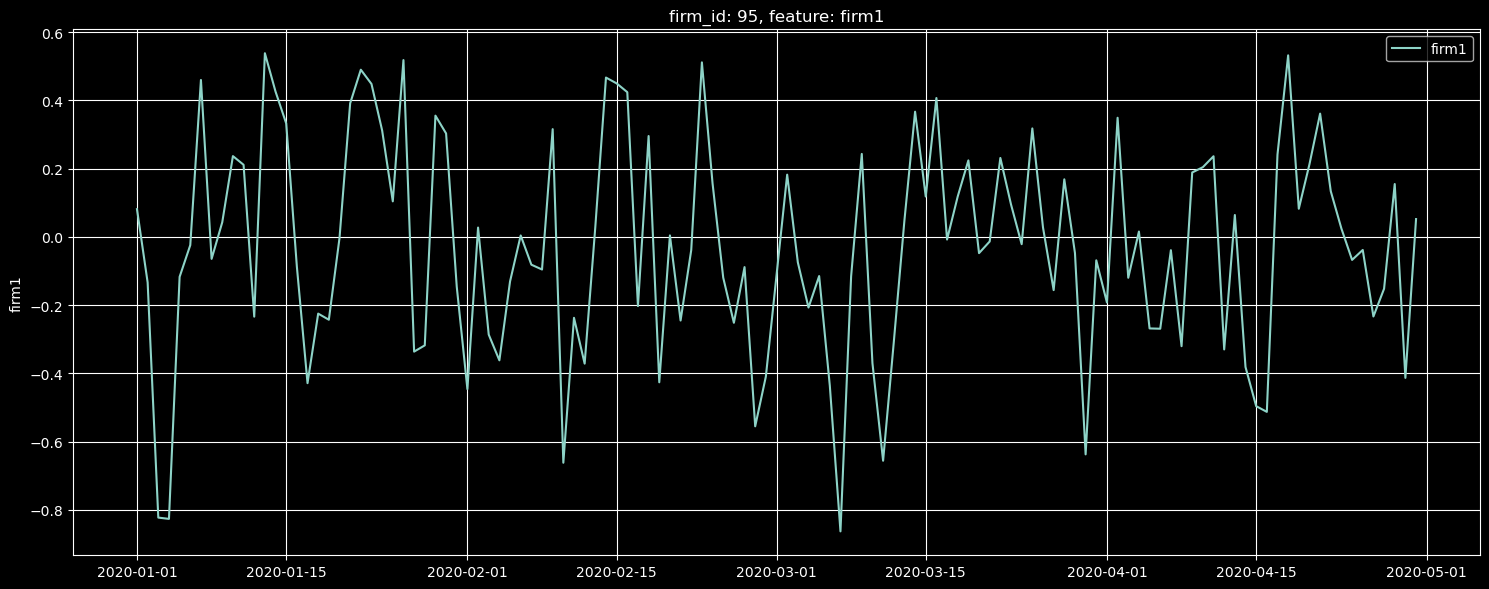

feature: firm2


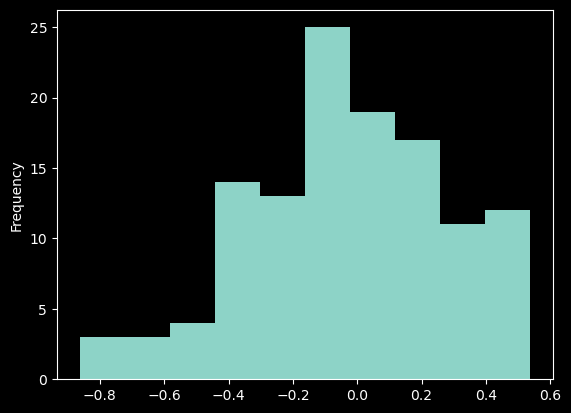

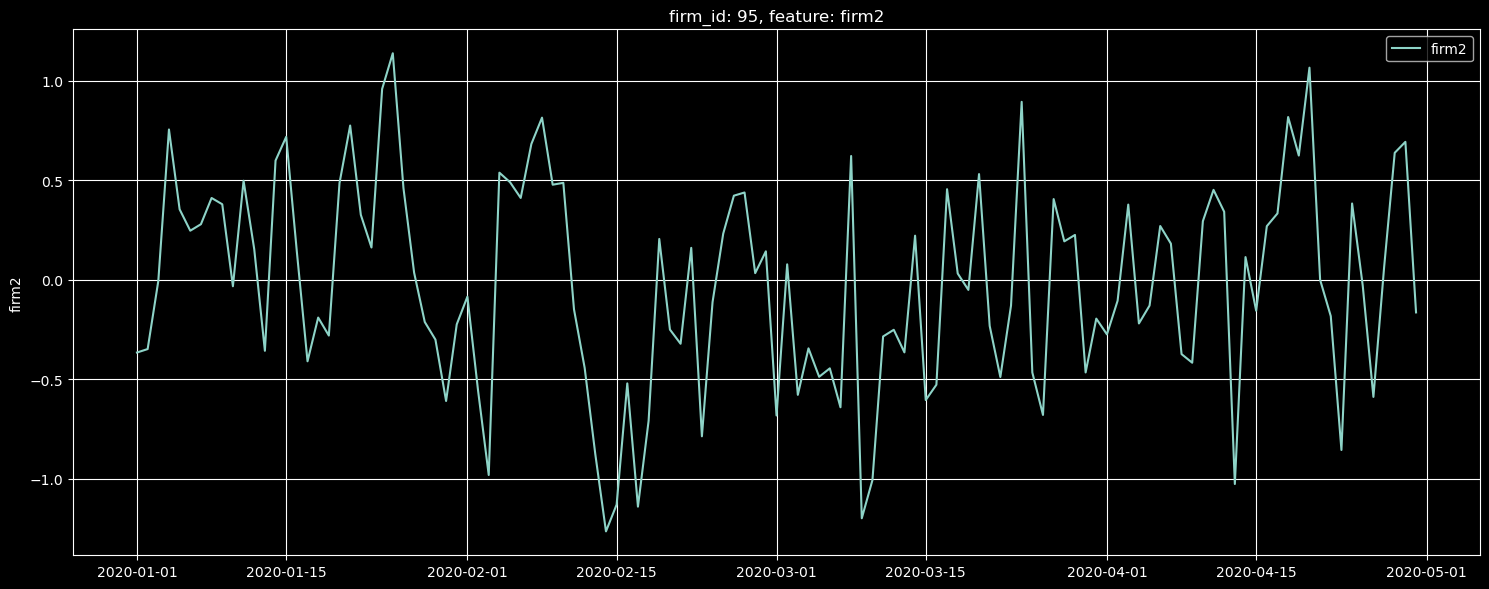

feature: firm3


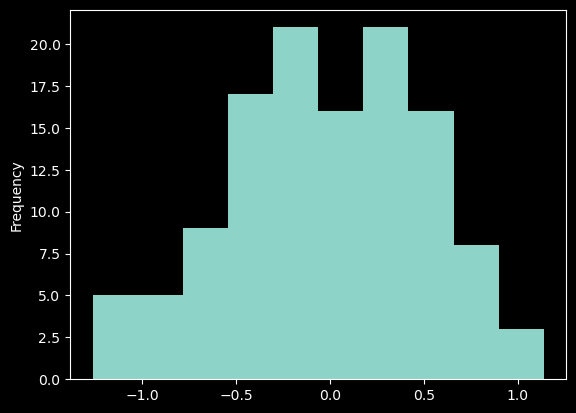

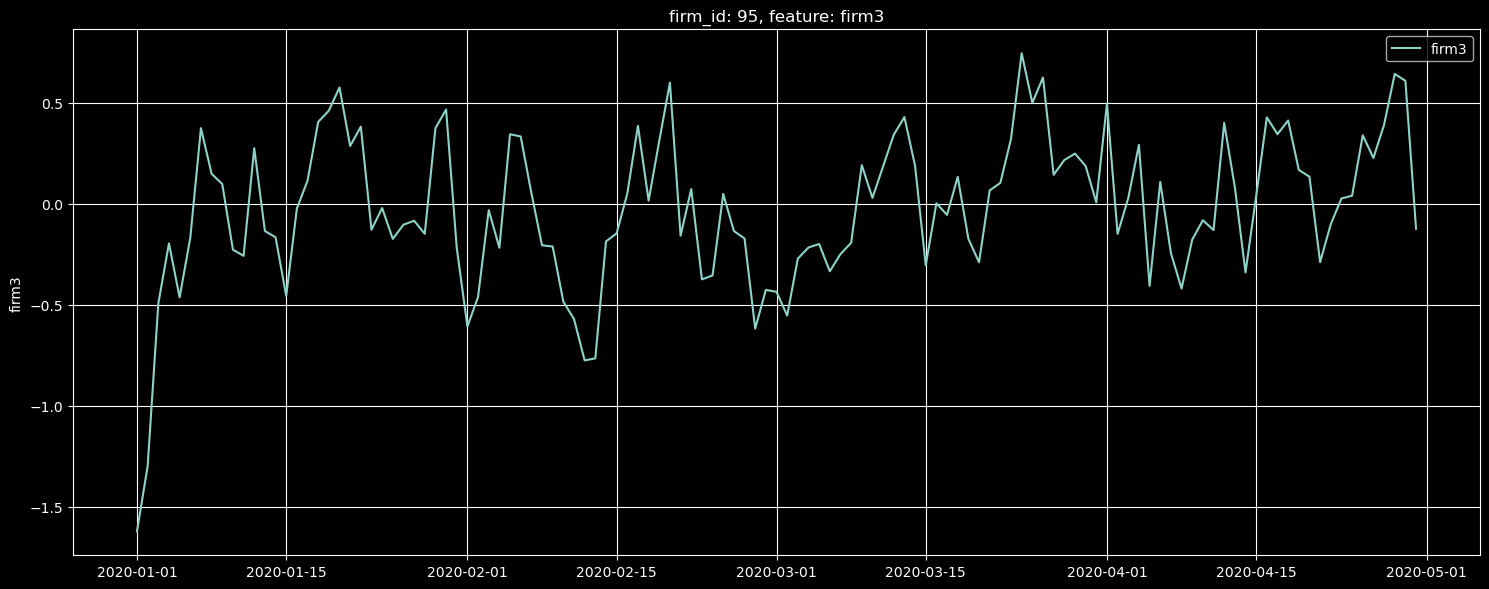

feature: ret


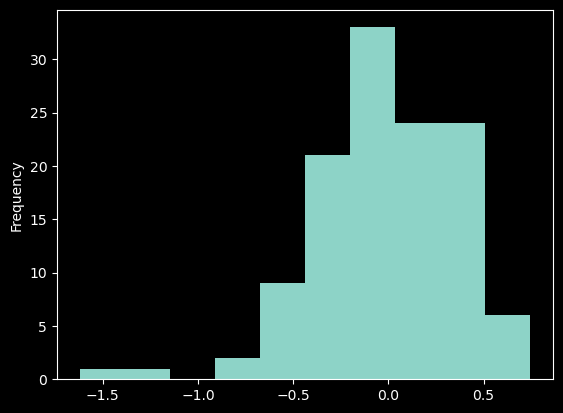

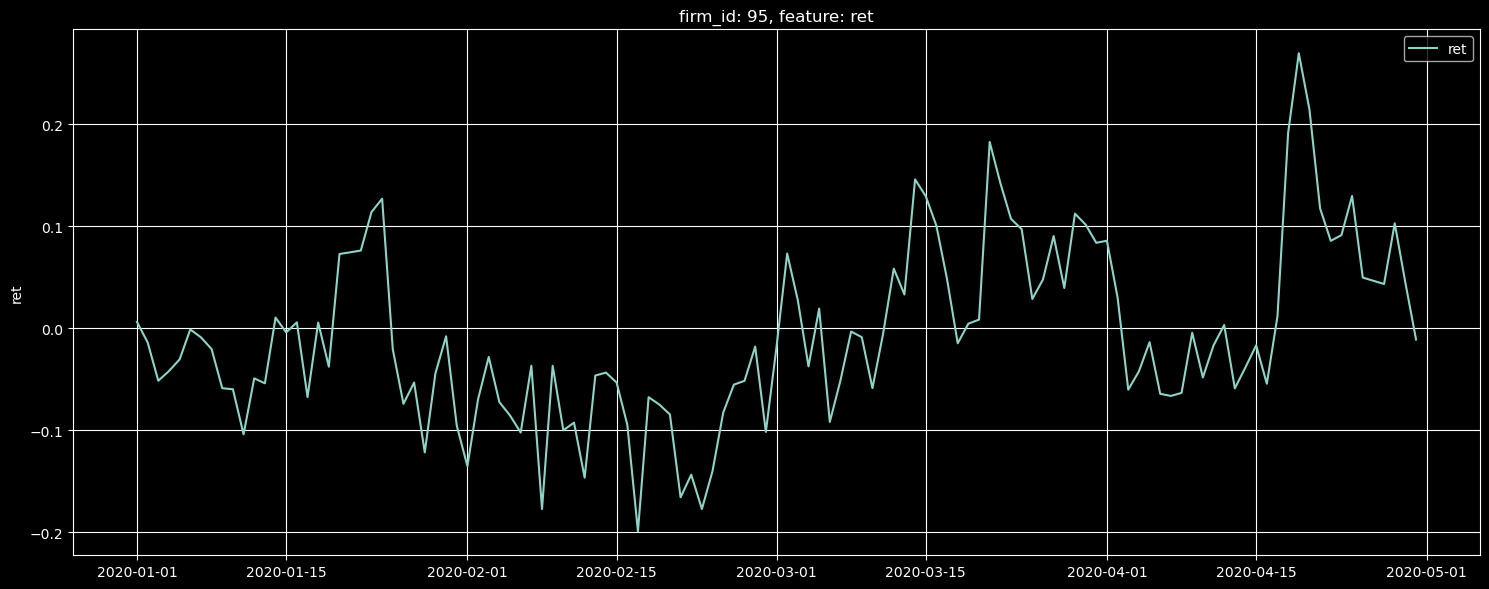

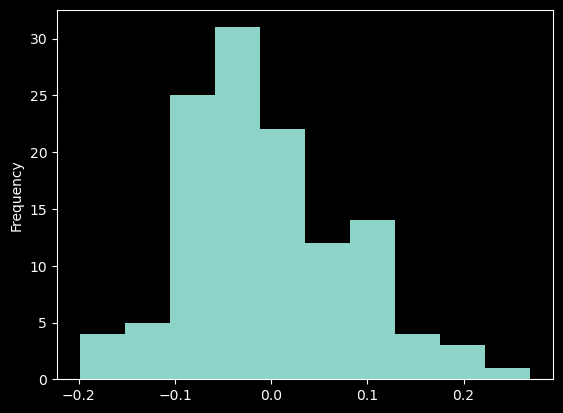

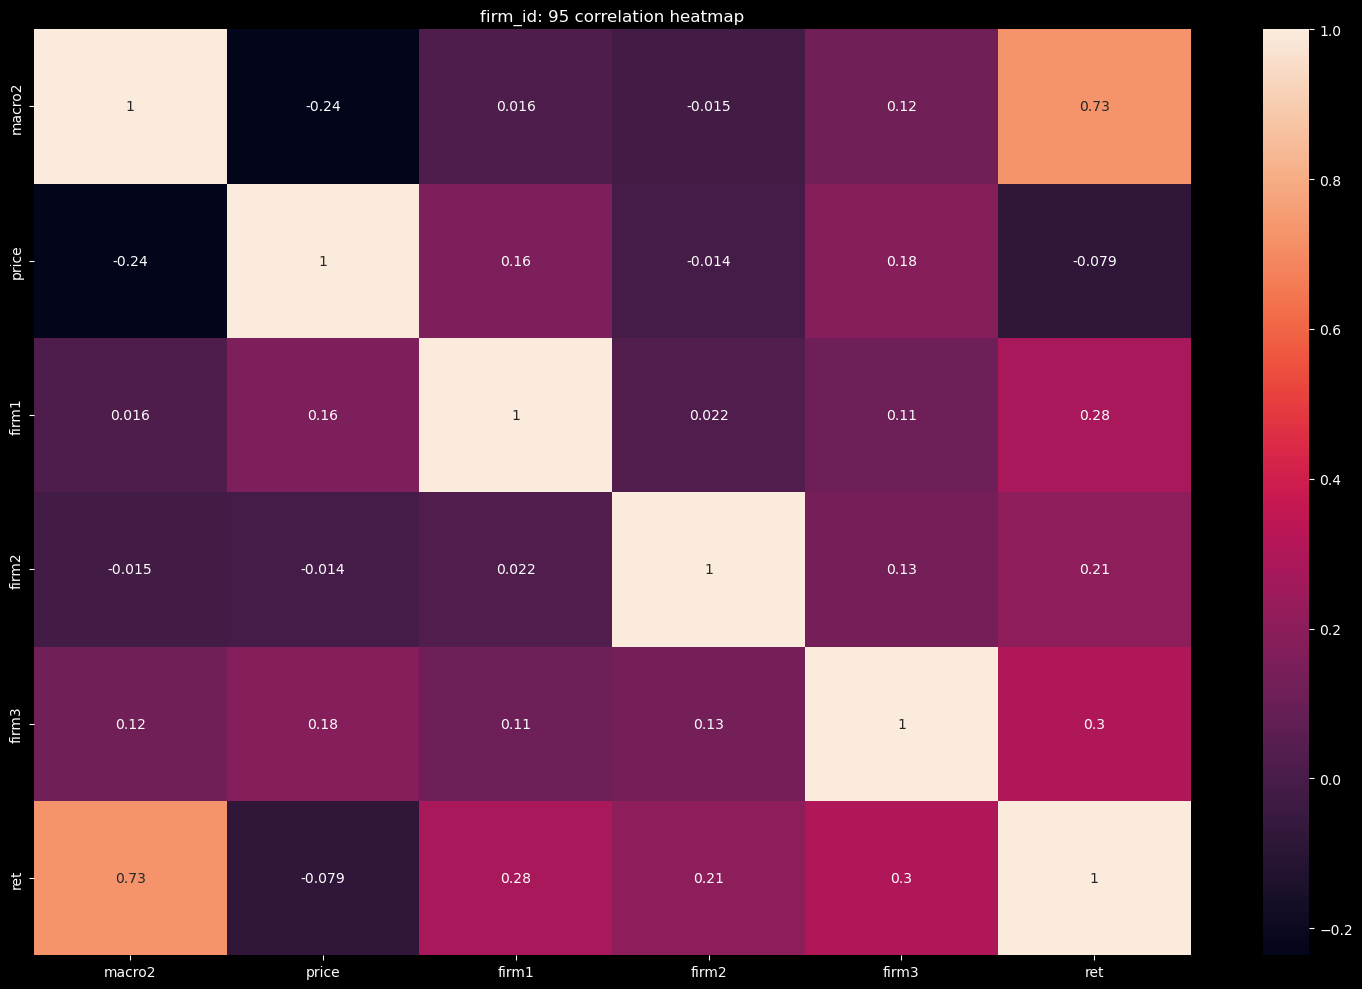

In [6]:
import random
def plot_data(firm_id, df, y_col, x_col = None):
    plt.figure(figsize=(15, 6))

    x = df[x_col] if x_col else df.index
    y = df[y_col]

    plt.plot(x, y, label=y_col)
    
    plt.title(f'firm_id: {firm_id}, feature: {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.grid(True)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_heatmap(firm_df, firm_id):
    plt.figure(figsize=(15,10))
    sns.heatmap(firm_df.loc[:, [i for i in firm_df.columns if i not in 
                                ['firm_id', 'macro1']]].corr(),
                                annot=True)
    plt.title(f'firm_id: {firm_id} correlation heatmap')
    plt.tight_layout()
    plt.show()


plot_df = train.sort_values(['date']).reset_index(drop = True).set_index(['date'])
firm_ids = train['firm_id'].unique()

firm_id = random.choice(list(firm_ids))
firm_df = plot_df[plot_df['firm_id'] == firm_id]
print(f'firm_id: {firm_id}')
for col in [i for i in firm_df.columns if i not in ['firm_id', 'macro1']]:
    print(f'feature: {col}')
    plot_data(firm_id, firm_df, col)
    firm_df[col].plot(kind='hist', bins=10)
plot_heatmap(firm_df, firm_id)

# Full Data Plots - Distribution

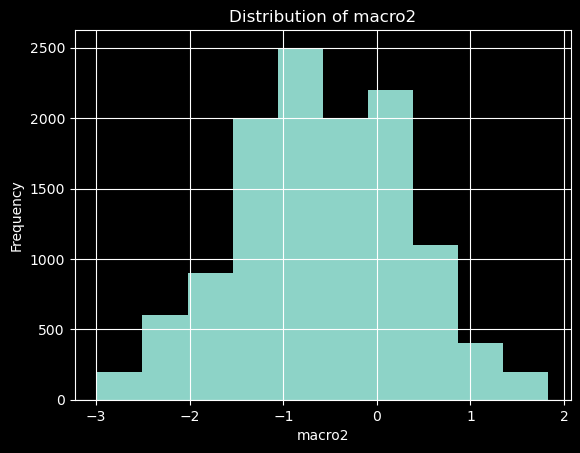

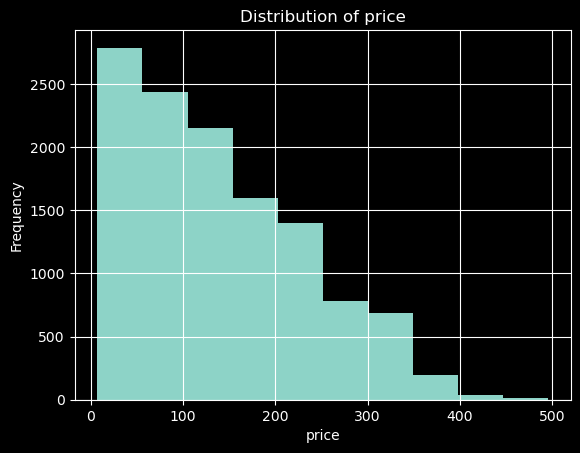

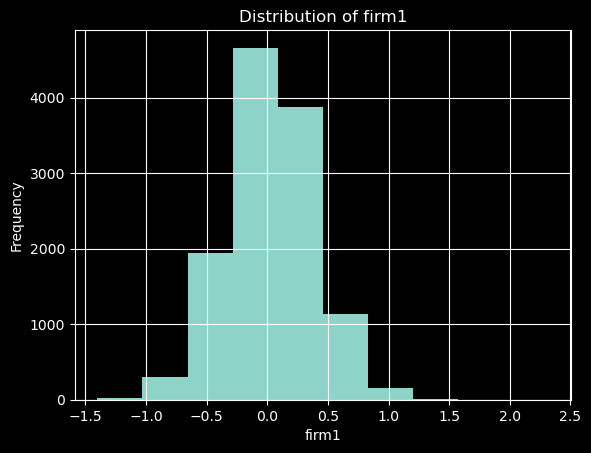

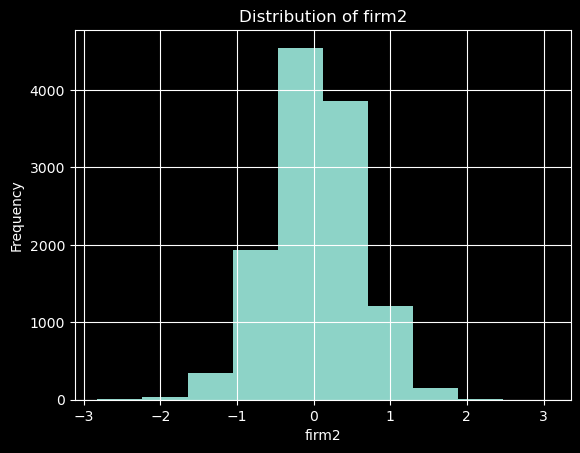

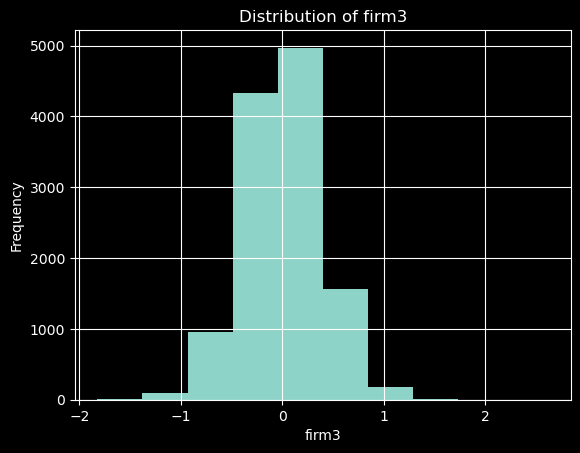

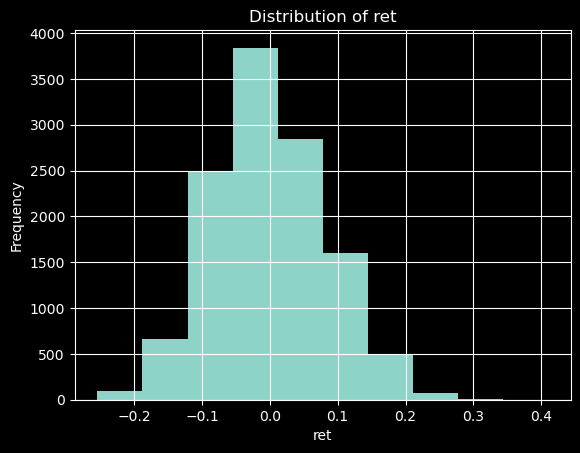

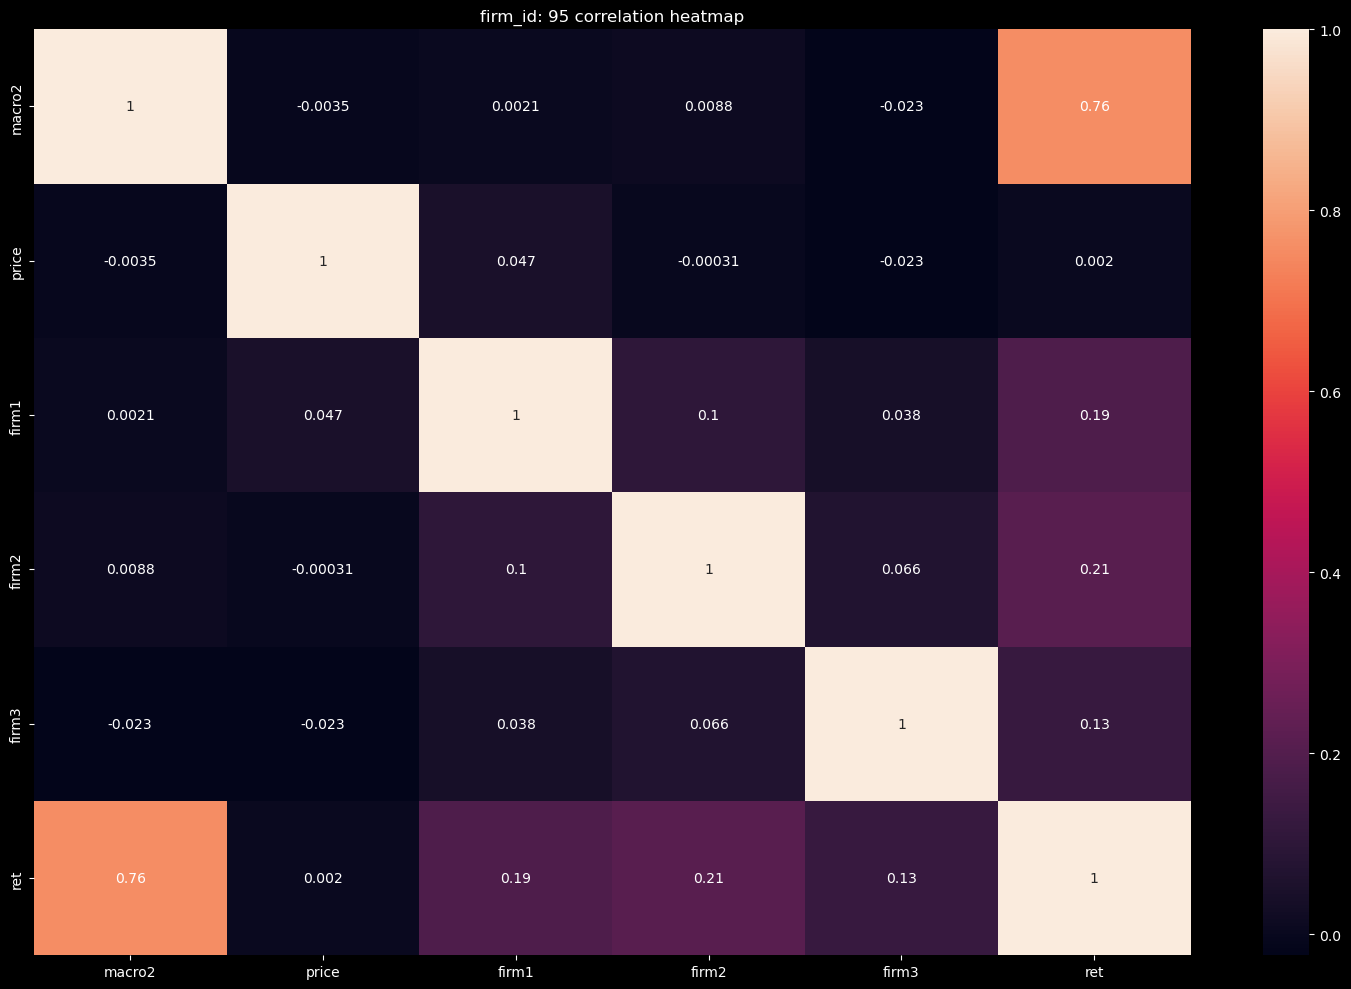

In [59]:
plot_df = raw_train.sort_values(['date']).reset_index(drop = True).set_index(['date'])
firm_ids = "ALL"

for col in [i for i in plot_df.columns if i not in ['firm_id', 'macro1']]:
    plot_df[col].plot(kind='hist', bins=10)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_heatmap(plot_df, firm_id)

In [22]:
# Missing Data and Outlier Handling

In [8]:
def missing_data_handling(df):
    for col in tqdm(df.columns):
        row_len = df[col].shape[0]
        nan_values_count = df[pd.isna(df[col])].shape[0]
        percentage = (nan_values_count/row_len) * 100
        print(f'column: {col} percentage missing values: {percentage:0.2f}%')


def winsorize_df(df, limits=(0.01, 0.01)):
    df_winsor = df.copy()
    for col in tqdm([i for i in df.columns if i not in ['firm_id', 'date', 'ret']]):
        print(f'applying winsorization to col: {col}')
        if pd.api.types.is_numeric_dtype(df[col]):
            # Apply winsorization only to numeric columns
            df_winsor[col] = winsorize(df[col], limits=limits)
            if df_winsor[col].equals(df[col]):
                print('no change')
    return df_winsor


missing_data_handling(train)
print('='*50)
winsorize_df(train)
print('='*50)


100%|██████████| 9/9 [00:00<00:00, 1349.81it/s]


column: date percentage missing values: 0.00%
column: firm_id percentage missing values: 0.00%
column: macro1 percentage missing values: 0.00%
column: macro2 percentage missing values: 0.00%
column: price percentage missing values: 0.00%
column: firm1 percentage missing values: 0.00%
column: firm2 percentage missing values: 0.00%
column: firm3 percentage missing values: 0.00%
column: ret percentage missing values: 0.00%


100%|██████████| 6/6 [00:00<?, ?it/s]

applying winsorization to col: macro1
applying winsorization to col: macro2
applying winsorization to col: price
applying winsorization to col: firm1
applying winsorization to col: firm2
applying winsorization to col: firm3


# Feature Engineering

In [9]:
def rolling_features(df, window_list = [20]):
    # relevant feature cols
    macro1_features = [i for i in df.columns if i.startswith('macro1')]
    columns = [i for i in df.columns if i not in ['firm_id', 'date', 'ret'] + macro1_features]

    # firm-wise rolling average feature generation for all numerical features
    for firm_id in tqdm(df['firm_id'].unique(), desc='rolling features per firm_id'):

        for col in columns:
            # mask by firm id and create rolling average for every numeric feature
            # print(f'generating feature for col: {col}')
            
            for window in window_list:
                # mean feature by firm_id
                df.loc[(df['firm_id'] == firm_id), f'{col}_rolling_avg_{int(window)}'] = (
                    df[(df['firm_id'] == firm_id)][col].rolling(window).mean()
                )

                # similarly for stdev
                df.loc[(df['firm_id'] == firm_id), f'{col}_rolling_std_{int(window)}'] = (
                    df[(df['firm_id'] == firm_id)][col].rolling(window).std()
                )

                # similarly for max
                df.loc[(df['firm_id'] == firm_id), f'{col}_rolling_max_{int(window)}'] = (
                    df[(df['firm_id'] == firm_id)][col].rolling(window).max()
                )

                # similarly for min
                df.loc[(df['firm_id'] == firm_id), f'{col}_rolling_min_{int(window)}'] = (
                    df[(df['firm_id'] == firm_id)][col].rolling(window).min()
                )

                # similarly for high/low
                df.loc[(df['firm_id'] == firm_id), f'{col}_rolling_high/low_{int(window)}'] = (
                    df[(df['firm_id'] == firm_id)][f'{col}_rolling_max_{int(window)}'] /
                    df[(df['firm_id'] == firm_id)][f'{col}_rolling_min_{int(window)}']
                )

                # similarly for high - low
                df.loc[(df['firm_id'] == firm_id), f'{col}_rolling_range_{int(window)}'] = (
                    df[(df['firm_id'] == firm_id)][f'{col}_rolling_max_{int(window)}'] -
                    df[(df['firm_id'] == firm_id)][f'{col}_rolling_min_{int(window)}']
                )

                # similarly for window return
                df.loc[(df['firm_id'] == firm_id), f'{col}_rolling_ret_{int(window)}'] = (
                    df[(df['firm_id'] == firm_id)][col] / 
                    df[(df['firm_id'] == firm_id)][col].shift(window - 1) - 1
                )
    return df

def feature_transformations(df):

    # relevant feature cols
    macro1_features = [i for i in df.columns if i.startswith('macro1')]
    columns = [i for i in df.columns if i not in ['firm_id', 'date', 'ret'] + macro1_features]

    for firm_id in tqdm(df['firm_id'].unique(), desc='generating feature transformations per firm_id'):

            for col in columns:
                 
                # create lagged features
                df.loc[(df['firm_id'] == firm_id), f'{col}_lag_1'] = (
                    df[(df['firm_id'] == firm_id)][col].shift(1)
                )
                
                # create squared cubed features
                df[f'{col}_squared'] = df[col] ** 2
                df[f'{col}_cubed'] = df[col] ** 3

            # create single period log returns
            df.loc[(df['firm_id'] == firm_id), f'{col}_log_ret'] = (
                np.log(df.loc[(df['firm_id'] == firm_id)]['price'] / df.loc[(df['firm_id'] == firm_id)]['price_lag_1']) 
            )


    return df

def feature_one_hot_encoding(df):
    
    print('one hot encoding categorical features')

    # one hot encoding and dropping the original feature
    dummies = pd.get_dummies(df['macro1'], prefix='macro1', drop_first=False)
    df = pd.concat([df.drop(columns=['macro1']), dummies], axis=1)
    
    return df

def feature_interactions(df):
    print('creating feature interactions')
    
    # firm features interactions
    df['firm1*firm2'] = df['firm1'] * df['firm2']
    df['firm2*firm3'] = df['firm2'] * df['firm3']
    df['firm1*firm3'] = df['firm1'] * df['firm3']

    # macro2 firm interactions
    df['firm1*macro2'] = df['firm1'] * df['macro2']
    df['firm2*macro2'] = df['firm2'] * df['macro2']
    df['firm3*macro2'] = df['firm3'] * df['macro2']

    # firm price interactions
    df['firm1*price'] = df['firm1'] * df['price']
    df['firm2*price'] = df['firm2'] * df['price']
    df['firm3*price'] = df['firm3'] * df['price']

    # price macro interactions
    df['macro2*price'] = df['macro2'] * df['price']
    
    # price ratios
    df['price/macro2'] = df['price'] / df['macro2']
    df['price/firm1'] = df['price'] / df['firm1']
    df['price/firm2'] = df['price'] / df['firm2']
    df['price/firm3'] = df['price'] / df['firm3']

    return df

def full_feature_engineering_pipeline(test):
    return (test.pipe(feature_interactions)
                .pipe(feature_one_hot_encoding)
                .pipe(feature_transformations)
                .pipe(rolling_features))


if not os.path.exists('./train+features.parquet'):
    train = full_feature_engineering_pipeline(train)
    train.to_parquet('./train+features.parquet')

creating feature interactions
one hot encoding categorical features


rolling features per firm_id: 100%|██████████| 100/100 [09:37<00:00,  5.78s/it]


# Train-Validation Split

In [3]:
def temporal_train_val_split(
    df: pd.DataFrame,
    date_col: str = "date",
    cutoff_frac: float = 0.80,
    keep_copy: bool = False,
):
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df = df.copy() if not keep_copy else df
        df[date_col] = pd.to_datetime(df[date_col])

    # Work on a copy only if requested
    _df = df.copy() if keep_copy else df

    # 1. Ensure chronological order
    _df.sort_values(date_col, inplace=True)

    # 2. Determine the cut-off date
    unique_dates = _df[date_col].unique()
    cutoff_idx   = int(len(unique_dates) * cutoff_frac)
    cutoff_date  = unique_dates[cutoff_idx - 1]        # zero-based index

    train_df = _df[_df[date_col] <= cutoff_date]
    val_df   = _df[_df[date_col] >  cutoff_date]


    return train_df, val_df


In [60]:
# df = pd.read_parquet("/mnt/data/training_data.parquet")  # your path
train, val = temporal_train_val_split(raw_train, cutoff_frac=0.8)

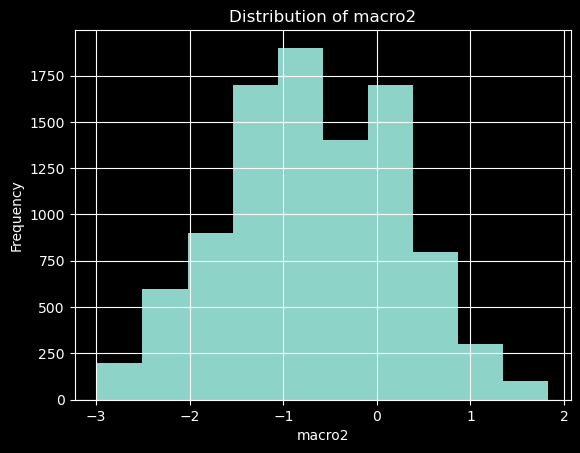

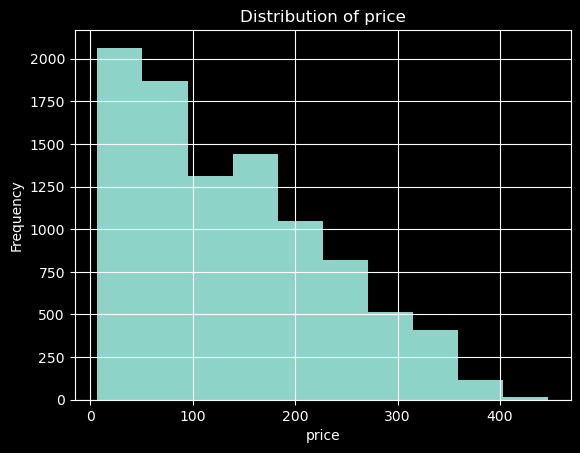

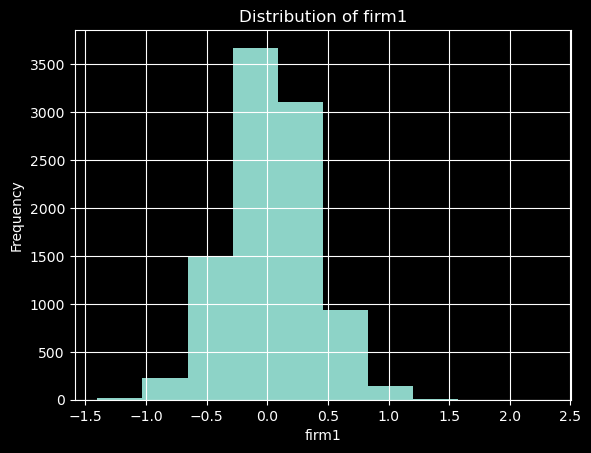

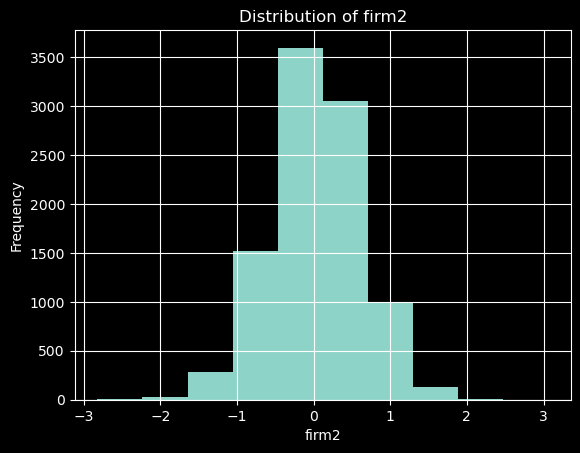

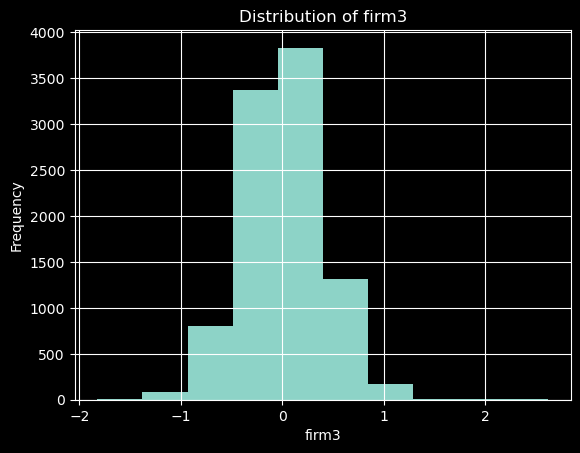

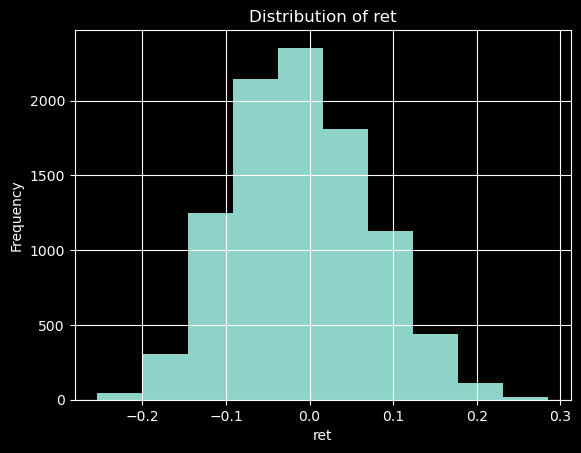

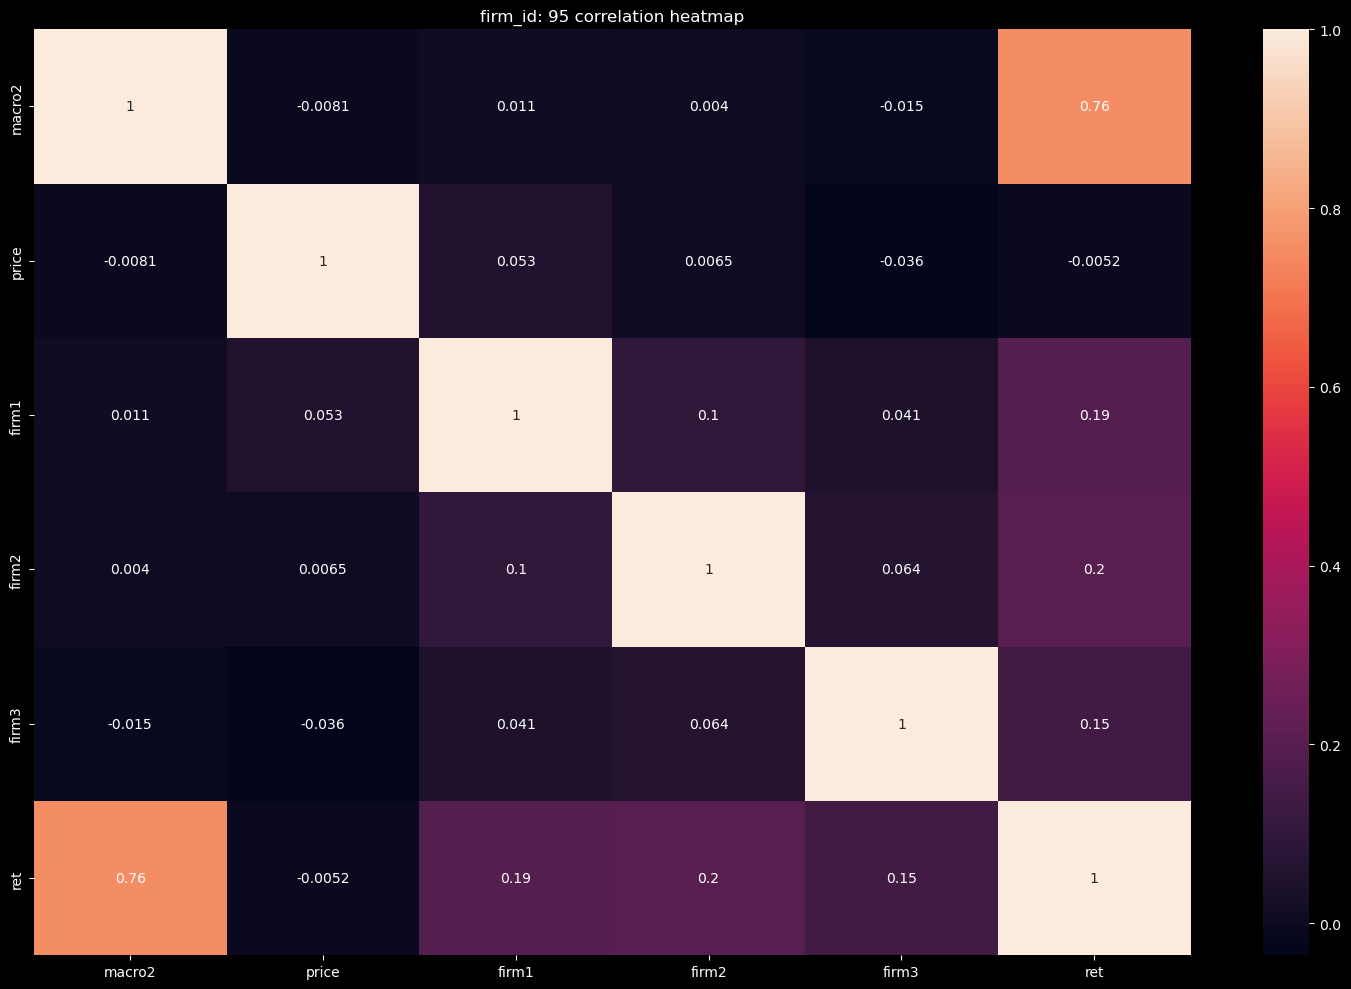

In [61]:
plot_df = train.sort_values(['date']).reset_index(drop = True).set_index(['date'])
firm_ids = 'ALL'

for col in [i for i in plot_df.columns if i not in ['firm_id', 'macro1']]:
    plot_df[col].plot(kind='hist', bins=10)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_heatmap(plot_df, firm_id)

# Elastic Net Implementation

In [ ]:
def prepare_X_y(df, target_col='ret', drop_cols=['date']):
    feature_cols = [col for col in df.columns if col not in drop_cols + [target_col]]
    X = df[feature_cols]
    y = df[target_col]

    # Encode categorical string columns if present
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X[col] = X[col].astype('category').cat.codes

    return X, y

def standardize_with_train_stats(
        train_df: pd.DataFrame,
        val_df:   pd.DataFrame
):
    train_scaled = train_df.copy()
    val_scaled   = val_df.copy()

    # --- identify columns -----------------------------------------------
    bool_cols   = train_df.select_dtypes(include=["bool"]).columns
    num_cols_all = train_df.select_dtypes(include=[np.number]).columns
    num_feat_cols = [c for c in num_cols_all if c not in bool_cols]

    # --- fit-transform ---------------------------------------------------
    scaler = StandardScaler().fit(train_df[num_feat_cols])

    train_scaled[num_feat_cols] = scaler.transform(train_df[num_feat_cols])
    val_scaled[num_feat_cols]   = scaler.transform(val_df[num_feat_cols])

    # --- keep booleans as 0/1 ints (no scaling) --------------------------
    train_scaled[bool_cols] = train_df[bool_cols].astype(int)
    val_scaled[bool_cols]   = val_df[bool_cols].astype(int)

    return train_scaled, val_scaled


In [ ]:
our_train = pd.read_parquet('./training_data.parquet')
train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
# Drop rows with NaN in train
train = train.dropna()

X_train, y_train = prepare_X_y(train, drop_cols=['date'])
X_val, y_val = prepare_X_y(val, drop_cols=['date'])
X_train_scaled, X_val_scaled = standardize_with_train_stats(X_train, X_val)

# Fit ElasticNetCV on training data
elastic_net = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                          alphas=[0.01, 0.1, 1, 10], 
                          cv=5, 
                          max_iter=5000, 
                          n_jobs=-1, 
                          random_state=42)
elastic_net.fit(X_train_scaled, y_train)

# Predict on validation set
y_pred = elastic_net.predict(X_val_scaled)

# Evaluation
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"ElasticNet best alpha: {elastic_net.alpha_}")
print(f"ElasticNet best l1_ratio: {elastic_net.l1_ratio_}")
print(f"Validation MSE: {mse:.4f}")
print(f"Validation R2: {r2:.4f}")

ElasticNet best alpha: 0.01
ElasticNet best l1_ratio: 0.1
Validation MSE: 0.0023
Validation R2: 0.5852


In [ ]:
our_train = pd.read_parquet('./train+features.parquet')
train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
# Drop rows with NaN in train
train = train.dropna()


X_train, y_train = prepare_X_y(train, drop_cols=['date'])
X_val, y_val = prepare_X_y(val, drop_cols=['date'])
X_train_scaled, X_val_scaled = standardize_with_train_stats(X_train, X_val)


# Fit ElasticNetCV on training data
elastic_net = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                          alphas=[0.01, 0.1, 1, 10], 
                          cv=5, 
                          max_iter=5000, 
                          n_jobs=-1, 
                          random_state=42)
elastic_net.fit(X_train_scaled, y_train)

# Predict on validation set
y_pred = elastic_net.predict(X_val_scaled)

# Evaluation
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"ElasticNet best alpha: {elastic_net.alpha_}")
print(f"ElasticNet best l1_ratio: {elastic_net.l1_ratio_}")
print(f"Validation MSE: {mse:.4f}")
print(f"Validation R2: {r2:.4f}")

ElasticNet best alpha: 0.01
ElasticNet best l1_ratio: 0.1
Validation MSE: 0.0017
Validation R2: 0.6963


# XGBoost Implementation

In [49]:
from xgboost import XGBRegressor

our_train = pd.read_parquet('./training_data.parquet')
train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
# Drop rows with NaN in train
train = train.dropna()


X_train, y_train = prepare_X_y(train, drop_cols=['date'])
X_val, y_val = prepare_X_y(val, drop_cols=['date'])
X_train_scaled, X_val_scaled = standardize_with_train_stats(X_train, X_val)


# Train XGBoost regressor
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_scaled, y_train)

# Predict on validation set
y_pred_xgb = xgb.predict(X_val_scaled)

# Evaluation
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

print(f"XGBoost Validation MSE: {mse_xgb:.4f}")
print(f"XGBoost Validation R2: {r2_xgb:.4f}")

XGBoost Validation MSE: 0.0025
XGBoost Validation R2: 0.5616


In [50]:
our_train = pd.read_parquet('./train+features.parquet')
train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
# Drop rows with NaN in train
train = train.dropna()


X_train, y_train = prepare_X_y(train, drop_cols=['date'])
X_val, y_val = prepare_X_y(val, drop_cols=['date'])
X_train_scaled, X_val_scaled = standardize_with_train_stats(X_train, X_val)


# Train XGBoost regressor
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_scaled, y_train)

# Predict on validation set
y_pred_xgb = xgb.predict(X_val_scaled)

# Evaluation
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

print(f"XGBoost Validation MSE: {mse_xgb:.4f}")
print(f"XGBoost Validation R2: {r2_xgb:.4f}")

XGBoost Validation MSE: 0.0018
XGBoost Validation R2: 0.6887
